# Imports

In [103]:
import git
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import geopandas as gp
from geopy.distance import geodesic

https://geopandas.org/en/stable/getting_started.html

# Update

In [6]:
git.Repo().git.pull()

'Already up to date.'

# Load data

In [7]:
airports = pd.read_csv('airports.csv', index_col='id')
runways = pd.read_csv('runways.csv', index_col='id')
freqs = pd.read_csv('airport-frequencies.csv', index_col='id')
countries = pd.read_csv('countries.csv', index_col='id')
regions = pd.read_csv('regions.csv', index_col='id')

# Search by distance

In [8]:
search = 'EGCC'
airport = airports.loc[airports['ident']==search]
x=100.0
y1=20.0
y2=20.0

In [9]:
freqs[freqs['airport_ident']==search]

,airport_ref,airport_ident,type,description,frequency_mhz
id,,,,,
58406,2398,EGCC,APP,APP,135.000
58407,2398,EGCC,ATIS,ATIS,128.175
58408,2398,EGCC,CLD,CLNC DEL,121.700
58409,2398,EGCC,GND,GND,121.850
58410,2398,EGCC,TWR,TWR,118.625
329164,2398,EGCC,TWR,NaN,119.400


In [10]:
runways[runways['airport_ident']==search]

,airport_ref,airport_ident,length_ft,width_ft,surface,lighted,closed,le_ident,le_latitude_deg,le_longitude_deg,le_elevation_ft,le_heading_degT,le_displaced_threshold_ft,he_ident,he_latitude_deg,he_longitude_deg,he_elevation_ft,he_heading_degT,he_displaced_threshold_ft
id,,,,,,,,,,,,,,,,,,,
239540,2398,EGCC,10000.0,148.0,ASP,1,0,05L,53.345100,-2.29274,212.0,51.0,1401.0,23R,53.362400,-2.25714,249.0,231.0,600.0
239539,2398,EGCC,10007.0,148.0,CON,1,0,05R,53.332001,-2.31066,186.0,51.0,604.0,23L,53.349098,-2.27499,227.0,231.0,604.0


In [11]:
airports['Distance'] = airports.apply(lambda row: geodesic(
    (airport['latitude_deg'].values[0], airport['longitude_deg'].values[0]), 
    (row['latitude_deg'],row['longitude_deg'])).nm, 
                                  axis=1
                                 ).round(1)


In [13]:
airports.sort_values('Distance').head(10)

,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,Distance
id,,,,,,,,,,,,,,,,,,
2398,EGCC,large_airport,Manchester Airport,53.349375,-2.279521,257.0,EU,GB,GB-ENG,Manchester,yes,EGCC,MAN,NaN,http://www.manchesterairport.co.uk/,https://en.wikipedia.org/wiki/Manchester_Airport,"Ringway Airport, RAF Ringway",0.0
319156,GB-0344,heliport,Wythenshawe Hospital Helipad,53.388414,-2.289633,NaN,EU,GB,GB-ENG,Manchester,no,NaN,NaN,NaN,NaN,NaN,NaN,2.4
521298,GB-1097,closed,RAF Cheadle,53.391312,-2.212458,NaN,EU,GB,GB-ENG,Cheadle,no,NaN,NaN,NaN,NaN,NaN,NaN,3.5
326746,GB-0547,small_airport,Pear Tree Farm Airstrip,53.279333,-2.297641,200.0,EU,GB,GB-ENG,Marthall,no,NaN,NaN,NaN,NaN,NaN,NaN,4.3
2399,EGCD,closed,Manchester Woodford Airport,53.338100,-2.148890,295.0,EU,GB,GB-ENG,Manchester,no,NaN,NaN,NaN,NaN,https://en.wikipedia.org/wiki/Woodford_Aerodrome,"EGCD, EGCD, XXB",4.7
35149,GB-0003,closed,Alexandra Park Aerodrome,53.436401,-2.250200,NaN,EU,GB,GB-ENG,Manchester,no,NaN,NaN,NaN,NaN,NaN,NaN,5.3
318145,GB-0306,closed,Lymm Dam Airstrip,53.368838,-2.476410,NaN,EU,GB,GB-ENG,Lymm,no,NaN,NaN,NaN,NaN,NaN,NaN,7.2
29114,EGCB,small_airport,City Airport Manchester,53.471699,-2.389720,73.0,EU,GB,GB-ENG,Manchester / Salford,no,EGCB,NaN,NaN,http://www.cityairportmanchester.com/,https://en.wikipedia.org/wiki/City_Airport_Man...,Barton Aerodrome,8.3
333149,GB-0733,small_airport,Fern Farm Airstrip UL,53.207400,-2.252800,NaN,EU,GB,GB-ENG,Marton,no,NaN,NaN,NaN,NaN,NaN,NaN,8.6


In [15]:
airports.where(
    (airports['Distance']>=x-y1) & 
    (airports['Distance']<=x+y2)
).dropna(how='all',axis=0).sort_values('Distance')

,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,Distance
id,,,,,,,,,,,,,,,,,,
334128,GB-0841,small_airport,Home Farm Airstrip,52.053300,-1.729000,NaN,EU,GB,GB-ENG,Ebrington (Glos),no,NaN,NaN,NaN,NaN,NaN,NaN,80.4
320285,GB-0388,small_airport,Pitsford Water,52.315300,-0.871944,330.0,EU,GB,GB-ENG,NaN,no,NaN,NaN,NaN,NaN,NaN,Moulton Grange Farm,80.5
337009,GB-0934,small_airport,Acthorpe Top Farm Airstrip,53.373703,-0.037165,NaN,EU,GB,GB-ENG,South Elkington,no,NaN,NaN,NaN,NaN,NaN,NaN,80.6
321057,GB-0462,small_airport,Octon Airstrip,54.126600,-0.430369,227.0,EU,GB,GB-ENG,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,80.8
320464,GB-0405,small_airport,Hardwicke Airstrip,52.085300,-3.061630,500.0,EU,GB,GB-ENG,Hardwicke,no,NaN,NaN,NaN,NaN,NaN,NaN,81.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333726,GB-0789,small_airport,Langham Airstrip,52.935500,0.954500,NaN,EU,GB,GB-ENG,"Holt, Norfolk",no,NaN,NaN,NaN,NaN,NaN,RAF Langham,119.5
332844,GB-0685,small_airport,Athey's Moor Airfield,55.316961,-1.785493,NaN,EU,GB,GB-ENG,Longframlington,no,NaN,NaN,NaN,NaN,NaN,NaN,119.5
316275,GB-0204,small_airport,Plaistows Airfield,51.728167,-0.380173,395.0,EU,GB,GB-ENG,"St Albans, Hertfordshire",no,NaN,NaN,NaN,NaN,NaN,Chiswell Green,119.7


# Airports by country

In [17]:
airports.groupby('iso_country').nunique()

,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,Distance
iso_country,,,,,,,,,,,,,,,,,
AD,3,2,3,3,3,1,1,2,2,1,0,0,0,0,1,0,3
AE,253,6,249,252,253,69,1,8,84,2,27,16,2,9,26,9,190
AF,82,4,80,81,81,66,1,29,64,2,45,33,1,2,37,33,78
AG,6,4,6,6,6,3,0,4,5,2,3,2,0,0,3,2,6
AI,2,2,2,2,2,1,0,1,2,2,1,1,0,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YE,43,4,43,43,43,31,1,16,32,2,23,22,3,0,19,11,42
YT,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1
ZA,652,6,651,647,651,495,1,10,499,2,321,92,8,30,67,61,604


# Airports by elevation

<Axes: ylabel='Frequency'>

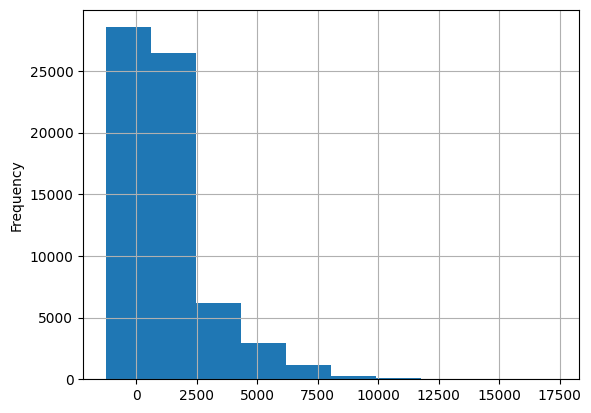

In [18]:
airports['elevation_ft'].plot.hist(grid=True)

# Airports by ISO region

In [19]:
airports.groupby('iso_region').nunique()

,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,Distance
iso_region,,,,,,,,,,,,,,,,,
AD-04,2,2,2,2,2,0,1,1,1,1,0,0,0,0,0,0,2
AD-08,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,0,1
AE-AJ,10,1,10,10,10,6,1,1,3,1,0,0,0,0,0,0,7
AE-AZ,150,6,147,150,150,41,1,1,53,2,18,7,1,4,16,6,129
AE-DU,22,5,21,22,22,10,1,1,8,2,3,5,0,4,4,2,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZW-MI,18,3,18,18,18,12,1,1,12,1,12,1,1,0,3,1,18
ZW-MN,34,4,34,34,34,28,1,1,21,2,14,3,0,0,3,3,33
ZW-MS,12,1,12,12,12,8,1,1,12,1,7,0,0,0,0,0,12


# Scheduled service

In [20]:
airports.groupby('scheduled_service').nunique()

,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,Distance
scheduled_service,,,,,,,,,,,,,,,,,
no,75960,7,71745,74887,75157,6199,6,227,2688,33391,38162,4807,31570,3004,11922,16890,37650
yes,4543,6,4532,4542,4540,1757,6,235,1702,4278,4393,4286,1236,1153,4381,1584,4380


# Maps

In [105]:
world = gp.read_file("ne_10m_admin_0_countries.geojson")

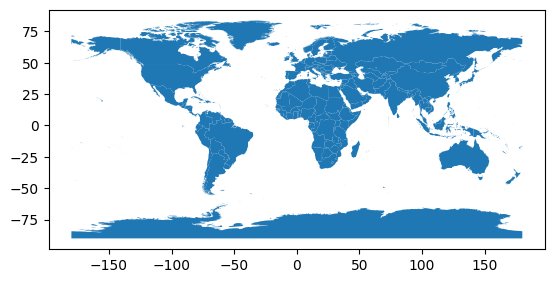

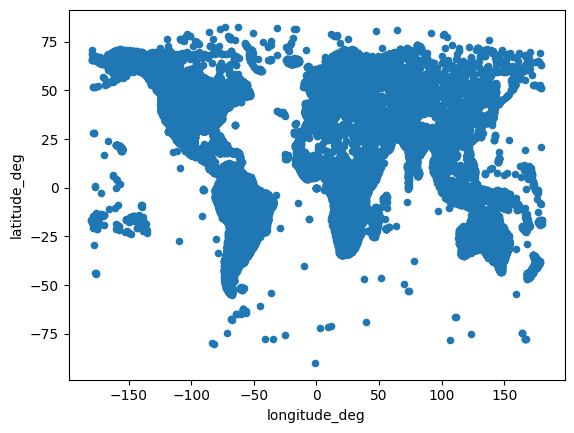

In [106]:
world.plot()
x=airports.plot.scatter(y="latitude_deg", x = "longitude_deg")

In [109]:
temp = airports.groupby("iso_country")["ident"].nunique()

<Axes: >

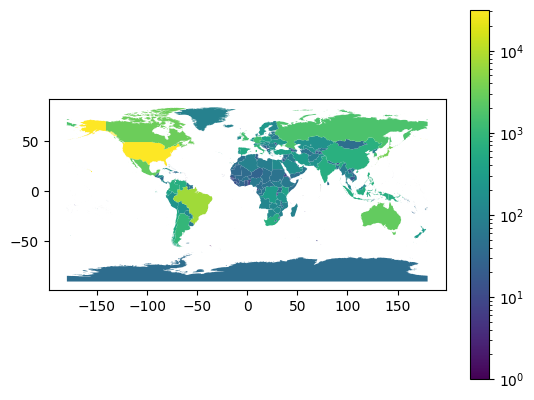

In [110]:
world.merge(temp, right_index=True, left_on="ISO_A2", how="left").plot("ident", legend=True, norm=LogNorm())